In [2]:
#Prerequesite installations
#Run once everytime runtime is restarted

import numpy as np
import cython

!pip install pystan
!pip install dionysus
!pip install ripser

import pystan as ps

     |████████████████████████████████| 1.0MB 5.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/18/42/ed/40d587d62cfde0767cb6d0d3fb9c8f5c9c64e83b647f14365d
Successfully built dionysus
     |████████████████████████████████| 81kB 5.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/95/6f/54/972a0889246bc3b1b47d769021bd61bb1d42153cdb58aa7fd3
Successfully built ripser


In [3]:
#Upload file/data
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving FirstData.xlsx to FirstData.xlsx


In [0]:
#Import empirical data
import numpy as np
import pandas as pd

xlsx = pd.ExcelFile('FirstData.xlsx')
df = pd.read_excel(xlsx, 'Wild Type')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

wild_type = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'Y130C')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

y130c = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'F53S')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

f53s = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'E203K')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

e203k = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])


#put all data into one data frame
bayes_td = np.array([wild_type, y130c, f53s, e203k])

In [0]:
def stan_model_yd(yeast_data, alt_ts = False):

  time_stamps = [0.5, 2, 3.25, 3.75, 5, 10, 20]
  
  if alt_ts:
    time_stamps = [0.5, 2, 3.25, 5, 10, 20, 40]

  yeast_code = """
  data {
      int<lower=0> T; // number of trials
      int<lower=0> TS; // number of timesteps
      vector[TS] ts; // time values
      real S0[TS,T]; // param S0
      real S1[TS,T]; // param S1
      real S2[TS,T]; // param S2
  }
  parameters {
      real P1;
      real P2;
      real Pi;
      real sigma1;
      //real sigma2;
      //real sigma3;
  }

  model {
      P1 ~ uniform(0,10);
      P2 ~ uniform(0,10);
      Pi ~ uniform(0,10);
      
      sigma1 ~ uniform(0,10);
      //sigma2 ~ uniform(0,10);
      //sigma3 ~ uniform(0,10);   

      for(i in 1:TS){
        real s0 = exp(-P1*ts[i]);
        real s1 = P1*(1-Pi)/(P1-P2)*(exp(-P2*ts[i]) - exp(-P1*ts[i]));
        real s2 = P1*Pi/(P1-P2)*(exp(-P2*ts[i]) - exp(-P1*ts[i])) + P2/(P1-P2)*(exp(-P1*ts[i]) - 1) + P1/(P1-P2)*(1-exp(-P2*ts[i]));
        
        S0[i, :] ~ normal(s0, sigma1);
        S1[i, :] ~ normal(s1, sigma1);
        S2[i, :] ~ normal(s2, sigma1);
      }
  }
  """

  S0 = np.stack([yeast_data[:, 0, 0], yeast_data[:, 1, 0], yeast_data[:, 2, 0], yeast_data[:, 3, 0], yeast_data[:, 4, 0], yeast_data[:, 5, 0], yeast_data[:, 6, 0]])
  S1 = np.stack([yeast_data[:, 0, 1], yeast_data[:, 1, 1], yeast_data[:, 2, 1], yeast_data[:, 3, 1], yeast_data[:, 4, 1], yeast_data[:, 5, 1], yeast_data[:, 6, 1]])
  S2 = np.stack([yeast_data[:, 0, 2], yeast_data[:, 1, 2], yeast_data[:, 2, 2], yeast_data[:, 3, 2], yeast_data[:, 4, 2], yeast_data[:, 5, 2], yeast_data[:, 6, 2]])

  S0 = np.array(S0, dtype = float)
  S1 = np.array(S1, dtype = float)
  S2 = np.array(S2, dtype = float)

  S0 = S0/5
  S1 = S1/5
  S2 = S2/5
  
  dimensions = yeast_data.shape

  yeast_dat = {'T': dimensions[0],
               'TS': dimensions[1],
               'ts': time_stamps,
               'S0': S0,
               'S1': S1,
               'S2': S2}

  sm = ps.StanModel(model_code=yeast_code)
  fit = sm.sampling(data=yeast_dat, iter=1000, chains=4)
  
  return fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.



 Bayesian model for yeast type 'WildType':
Inference for Stan model: anon_model_8c8cef31884796c806a78281f651d649.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1       0.29  4.3e-4   0.02   0.26   0.28   0.29    0.3   0.32   1408    1.0
P2       0.19  2.1e-3   0.05   0.13   0.16   0.19   0.22   0.31    478   1.01
Pi        0.3  3.6e-3   0.08   0.11   0.25   0.31   0.35   0.43    506   1.01
sigma1    0.1  1.9e-4 7.2e-3   0.09    0.1    0.1   0.11   0.12   1474    1.0
lp__   185.62    0.06   1.58 181.79 184.82 186.01 186.78 187.54    602    1.0

Samples were drawn using NUTS at Fri May 10 09:52:30 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.



 Bayesian model for yeast type 'Y130C':
Inference for Stan model: anon_model_8c8cef31884796c806a78281f651d649.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1       0.36  3.9e-4   0.01   0.34   0.35   0.36   0.37   0.39   1428    1.0
P2       0.16  6.8e-4   0.02   0.13   0.15   0.16   0.17    0.2    660   1.01
Pi        0.3  1.4e-3   0.04   0.23   0.28    0.3   0.33   0.37    643   1.01
sigma1   0.07  1.2e-4 4.9e-3   0.06   0.07   0.07   0.08   0.08   1738    1.0
lp__   224.12    0.06   1.46 220.46 223.41 224.49 225.16 225.94    641    1.0

Samples were drawn using NUTS at Fri May 10 09:53:42 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.



 Bayesian model for yeast type 'F53S':
Inference for Stan model: anon_model_8c8cef31884796c806a78281f651d649.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1       0.41  6.1e-4   0.02   0.37   0.39   0.41   0.42   0.45   1309    1.0
P2       0.16  7.6e-4   0.02   0.12   0.15   0.16   0.18   0.21    895    1.0
Pi       0.28  1.5e-3   0.05   0.19   0.25   0.28   0.31   0.37    881    1.0
sigma1   0.09  1.5e-4 6.4e-3   0.08   0.09   0.09   0.09    0.1   1780    1.0
lp__   200.53    0.05   1.52 196.71 199.82 200.88 201.64 202.36    880    1.0

Samples were drawn using NUTS at Fri May 10 09:54:54 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

 Bayesian model for yeast type 'E203K':
Inference for Stan model: anon_model_8c8c

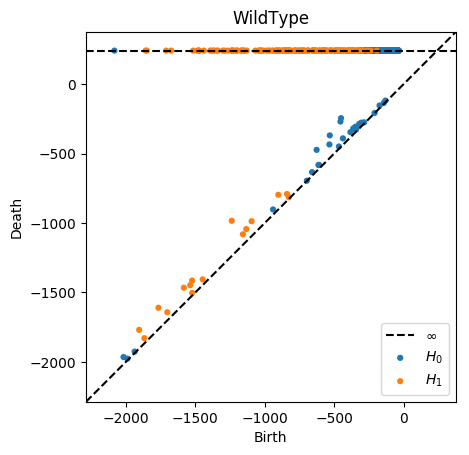

Y130C
[0.0068193  0.00422389 0.00858692]


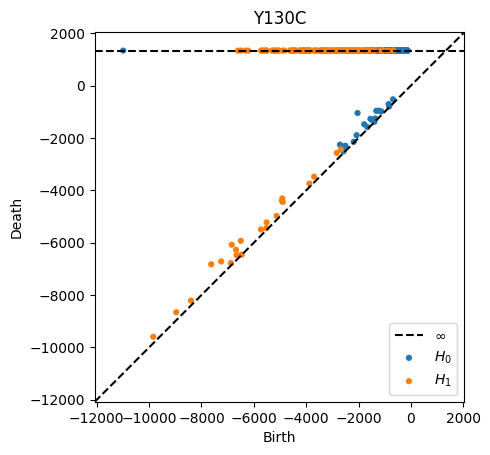

F53S
[0.01042835 0.00532428 0.01040946]


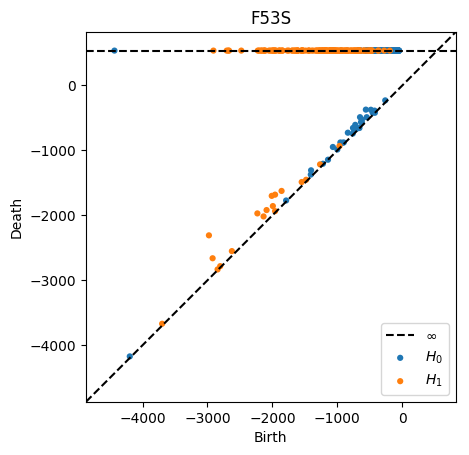

E203K
[0.02006758 0.00550438 0.00911724]


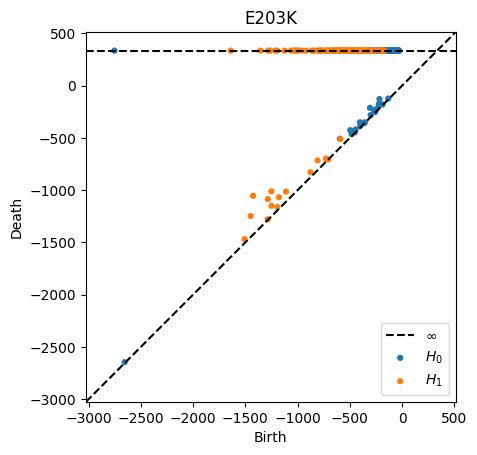

Bottleneck distance of PDs of WildType and Y130C:
[494.6944580078125, 401.599853515625]
2-Wasserstein distance of PDs of WildType and Y130C:
[nan, nan]

Bottleneck distance of PDs of WildType and F53S:
[102.70771026611328, 334.725830078125]
2-Wasserstein distance of PDs of WildType and F53S:
[nan, nan]

Bottleneck distance of PDs of WildType and E203K:


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1015: RuntimeWarning: invalid value encountered in subtract
  l1_diff = abs(u - v)


[102.70771026611328, 186.39715576171875]
2-Wasserstein distance of PDs of WildType and E203K:
[nan, nan]

Bottleneck distance of PDs of Y130C and F53S:
[494.6944580078125, 401.599853515625]
2-Wasserstein distance of PDs of Y130C and F53S:
[nan, nan]

Bottleneck distance of PDs of Y130C and E203K:
[494.6944580078125, 401.599853515625]
2-Wasserstein distance of PDs of Y130C and E203K:
[nan, nan]

Bottleneck distance of PDs of F53S and E203K:
[65.79345703125, 334.725830078125]
2-Wasserstein distance of PDs of F53S and E203K:
[nan, nan]



In [10]:
import dionysus as d
import numpy as np
from numpy import linalg
from scipy.stats import multivariate_normal, gaussian_kde
import math
import statistics
from statsmodels.nonparametric.kernel_density import KDEMultivariate

from ripser import ripser
from persim import plot_diagrams, bottleneck, images, sliced_wasserstein
import matplotlib.pyplot as plt



def build_filtration(X, r, kernel):  
  
  est = KDEMultivariate(data=[np.array(X[:,0]),
                              np.array(X[:,1]),
                              np.array(X[:,2])],
                              bw='cv_ml',
                              var_type='ccc')
  print(est.bw)
  
  filt = d.fill_rips(X, 2, statistics.mean(est.bw))
    
  data_points = {}
  
  for i in range(len(X)):
    data_points.update({i : est.pdf(X[i])})
    
  for simplex in filt:
    min_val = 1000000
    for vertex in simplex:
      #print(data_points[vertex])
      new_val = data_points[vertex]
      
      if new_val < min_val:
        min_val = new_val
    
    simplex.data = -min_val
      
  filt.sort()
  
  
  return filt, est


def gaussian_kernel(x, y ,z):
  input_x = [x, y, z]
  return multivariate_normal.pdf(input_x, mean=[0,0,0], cov=[[1,0,0],[0,1,0],[0,0,1]])

def triangular_kernel(x, y, z):
  input_x = [x, y, z]
  norm = linalg.norm(input_x, 2)
  
  if norm/(math.sqrt(math.pi/3)) > 1:
    return 0
  else:
    return 1 - norm/((math.pi/3)**(1./3))
  
def bottleneck_distance(dgm1, dgm2):
  dim = len(dgm1)
  
  distance = []
  
  for i in range(dim):
    distance.append(bottleneck(dgm1[i], dgm2[i]))
    
  return distance

def wasserstein_distance(dgm1, dgm2):
  dim = len(dgm1)
  
  distance = []
  
  for i in range(dim):
    distance.append(sliced_wasserstein(dgm1[i], dgm2[i], 20))
    
  return distance

  

y_type = ['WildType', 'Y130C', 'F53S', 'E203K']

"""
total_bayes_data = []

for i in range(len(y_type)):
  fit = stan_model_yd(bayes_td[i])
  
  print('\n Bayesian model for yeast type %r:' % y_type[i])
  print(fit)

  posterior = fit.extract()
  bayes_data = np.stack([posterior['P1'], posterior['P2'], posterior['Pi']])
  bayes_data = np.swapaxes(bayes_data, 0, 1)
  total_bayes_data.append(bayes_data)
"""
  
all_dgms = []
all_kdes = []

for i in range(len(y_type)):
  print(y_type[i])
  filt, kde = build_filtration(total_bayes_data[i], 0.005, gaussian_kernel)
  
  all_kdes.append(kde)

  hom = d.homology_persistence(filt)
  
  dgms = d.init_diagrams(hom, filt)
  

  #d.plot.plot_bars(dgms[0], show = True)
  
  rp_dgm_0 = []
  
  for point in dgms[0]:
    rp_dgm_0.append((point.birth, point.death))
    
  rp_dgm_0 = np.array(rp_dgm_0)
  
  rp_dgm_1 = []
  
  for point in dgms[1]:
    rp_dgm_1.append((point.birth, point.death))
    
  rp_dgm_1 = np.array(rp_dgm_1)
    
  #d.plot.plot_bars(dgms[1], show = True)
  
  rp_dgm_2 = []
  
  for point in dgms[2]:
    rp_dgm_2.append((point.birth, point.death))
    
  rp_dgm_2 = np.array(rp_dgm_2)
  
  rp_dgm = list([rp_dgm_0, rp_dgm_1])
  
  plot_diagrams(rp_dgm, title=y_type[i])
  plt.show()
  
  all_dgms.append(rp_dgm)


for i in range(3):
  for j in range(i + 1, 4):
    print('Bottleneck distance of PDs of %s and %s:' % (y_type[i], y_type[j]))
    print(bottleneck_distance(all_dgms[i], all_dgms[j]))
    #print('2-Wasserstein distance of PDs of %s and %s:' % (y_type[i], y_type[j]))
    #print(wasserstein_distance(all_dgms[i], all_dgms[j]))
    print('')
    

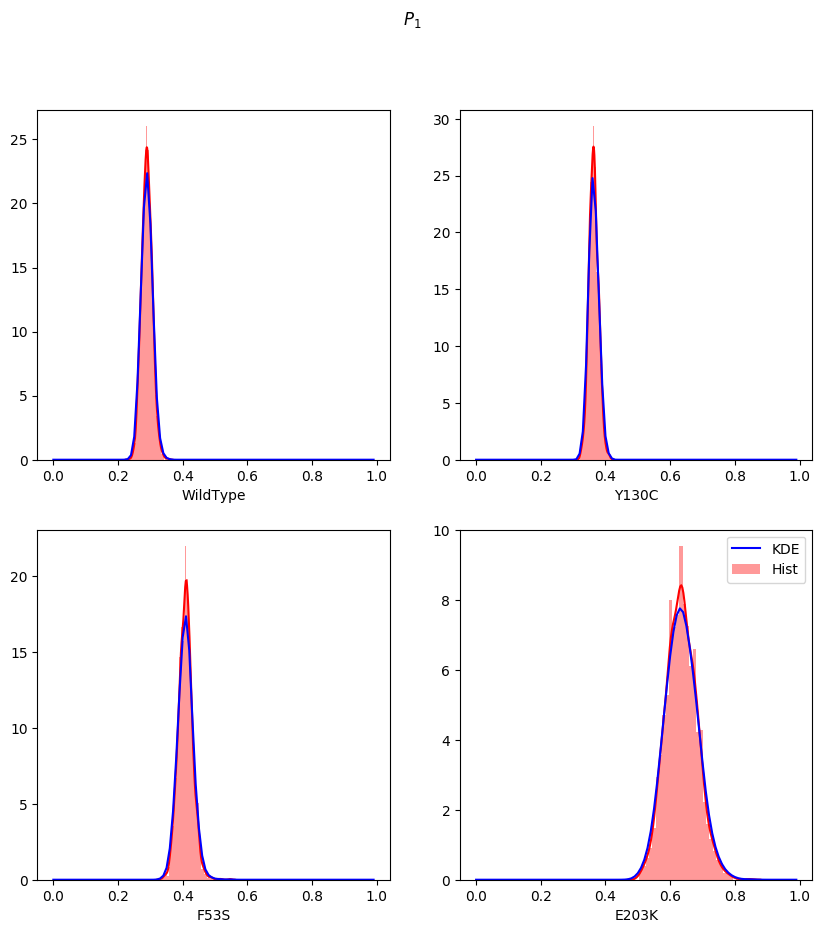

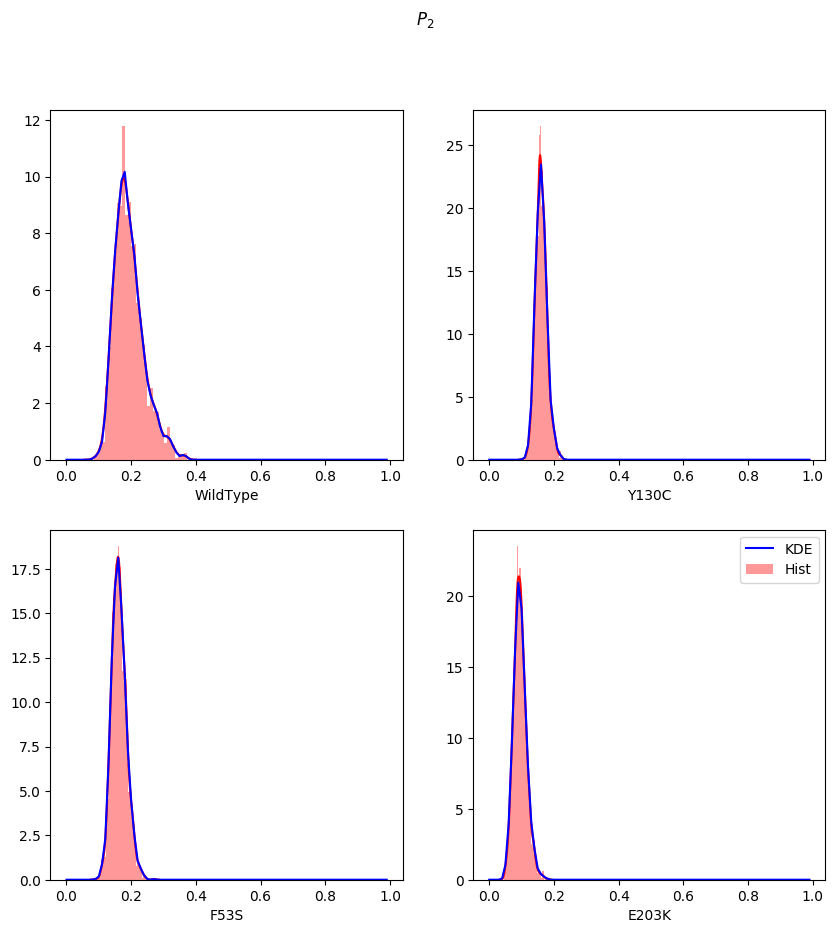

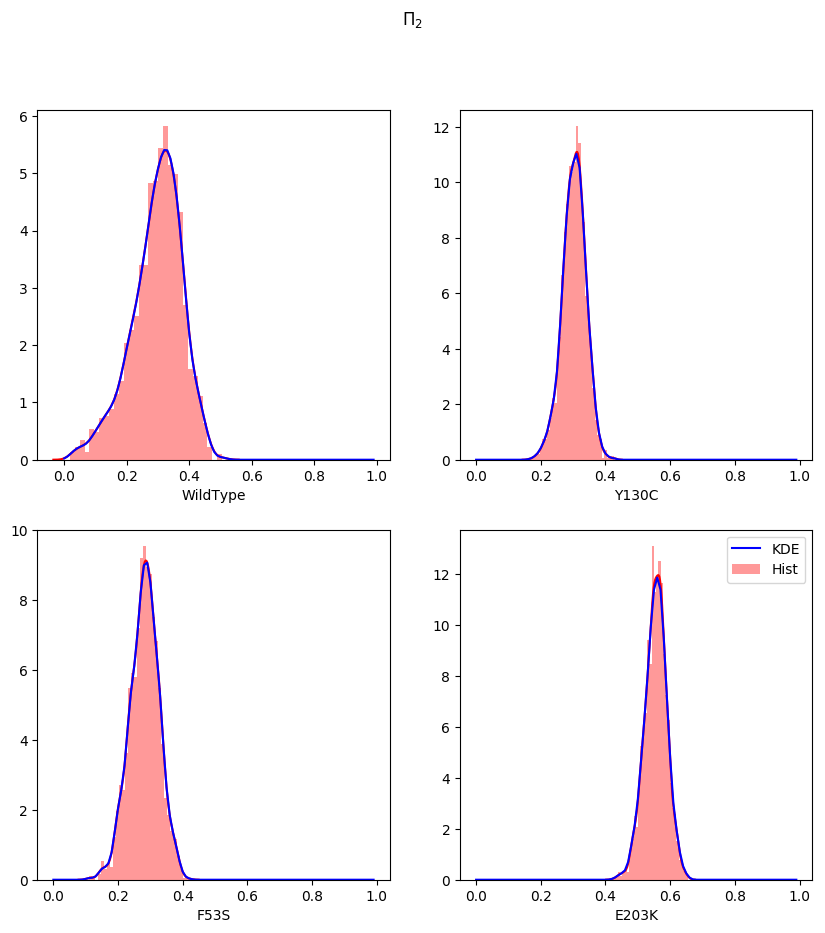

In [38]:
## Plotting KDEs

import seaborn as sns


x_range = np.arange(0, 1, 0.01)

#P1
plt.figure(figsize=(10,10))
plt.suptitle(r'$P_1$')
for i in range(len(y_type)):
  plt.subplot(2, 2, i + 1)
    
  y_func = lambda x : statistics.mean([float(all_kdes[i].pdf([x,y,z])) for z in x_range for y in x_range])
  y_range = [y_func(x) for x in x_range]
  
  sns.distplot(total_bayes_data[i][:, 0], color = 'r', axlabel = y_type[i], label = 'Hist', norm_hist = True)
  plt.plot(x_range, y_range, color='b', label='KDE')

plt.legend(loc='upper right')
plt.show()


#P2
plt.figure(figsize=(10,10))  
plt.suptitle(r'$P_2$')
for i in range(len(y_type)):
  plt.subplot(2, 2, i + 1)
    
  y_func = lambda y : statistics.mean([float(all_kdes[i].pdf([x,y,z])) for x in x_range for z in x_range])
  y_range = [y_func(x) for x in x_range]
  
  sns.distplot(total_bayes_data[i][:, 1], color = 'r', axlabel = y_type[i], label = 'Hist', norm_hist = True)
  plt.plot(x_range, y_range, color='b', label='KDE')

plt.legend(loc='upper right')
plt.show()


#Pi2
plt.figure(figsize=(10,10))
plt.suptitle(r'$\Pi_2$')
for i in range(len(y_type)):
  plt.subplot(2, 2, i + 1)
    
  y_func = lambda z : statistics.mean([float(all_kdes[i].pdf([x,y,z])) for x in x_range for y in x_range])
  y_range = [y_func(x) for x in x_range]
  
  sns.distplot(total_bayes_data[i][:, 2], color = 'r', axlabel = y_type[i], label = 'Hist', norm_hist = True)
  plt.plot(x_range, y_range, color='b', label='KDE')

plt.legend(loc='upper right')
plt.show()
